In [1]:
import pandas as pd 
import tensorflow as tf
import datetime
import csv
import numpy as np
import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM
from keras import backend
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 


Using TensorFlow backend.


In [0]:

####################################################### - Data loading + info - ########################################################

#uploading data
source_data = pd.read_csv("data.csv")

#Check infos from the source
#print(source_data.info())

"""
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   data                               25 non-null     object 
 1   data_dados                         25 non-null     object 
 2   confirmados                        25 non-null     int64  
 3   confirmados_arsnorte               25 non-null     int64  
 4   confirmados_arscentro              25 non-null     int64  
 5   confirmados_arslvt                 25 non-null     int64  
 6   confirmados_arsalentejo            25 non-null     int64  
 7   confirmados_arsalgarve             25 non-null     int64  
 8   confirmados_acores                 25 non-null     int64  
 9   confirmados_madeira                25 non-null     int64  
 10  confirmados_estrangeiro            10 non-null     float64
 11  confirmados_novos                  25 non-null     int64  
 12  recuperados                        25 non-null     int64  
 13  obitos                             25 non-null     int64  
 14  internados                         17 non-null     float64
 15  internados_uci                     8 non-null      float64
 16  lab                                16 non-null     float64
 17  suspeitos                          25 non-null     int64  
 18  vigilancia                         18 non-null     float64
 19  n_confirmados                      7 non-null      float64
 20  cadeias_transmissao                15 non-null     float64
 21  transmissao_importada              19 non-null     float64
 22  confirmados_0_9_f                  19 non-null     float64
 23  confirmados_0_9_m                  19 non-null     float64
 24  confirmados_10_19_f                19 non-null     float64
 25  confirmados_10_19_m                19 non-null     float64
 26  confirmados_20_29_f                19 non-null     float64
 27  confirmados_20_29_m                19 non-null     float64
 28  confirmados_30_39_f                19 non-null     float64
 29  confirmados_30_39_m                19 non-null     float64
 30  confirmados_40_49_f                19 non-null     float64
 31  confirmados_40_49_m                19 non-null     float64
 32  confirmados_50_59_f                19 non-null     float64
 33  confirmados_50_59_m                19 non-null     float64
 34  confirmados_60_69_f                19 non-null     float64
 35  confirmados_60_69_m                19 non-null     float64
 36  confirmados_70_79_f                19 non-null     float64
 37  confirmados_70_79_m                19 non-null     float64
 38  confirmados_80_plus_f              19 non-null     float64
 39  confirmados_80_plus_m              19 non-null     float64
 40  sintomas_tosse                     19 non-null     float64
 41  sintomas_febre                     19 non-null     float64
 42  sintomas_dificuldade_respiratoria  17 non-null     float64
 43  sintomas_cefaleia                  19 non-null     float64
 44  sintomas_dores_musculares          19 non-null     float64
 45  sintomas_fraqueza_generalizada     19 non-null     float64
 46  confirmados_f                      3 non-null      float64
 47  confirmados_m                      3 non-null      float64
"""
#######################################################################################################################################
####################################################### - Data treatment - ############################################################

#Set the seed
np.random.seed(12345)

#Filtering some columns
source_data = source_data[['data', 'confirmados']]

#set the date as an index
source_data = source_data.set_index('data')

#Convert numpy array to dataframe
source_data = pd.DataFrame(source_data)
"""
Normalize data between -1 and 1
Because the use of tanh in LSTM
"""
def normalize(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data[['confirmados']] = scaler.fit_transform(data[['confirmados']])
    return scaler, data

#Turn unsupervised learning in supervised
def sequence_pred(dataframe, timesteps):
    data_values = dataframe.values
    X, y = list(), list()
    size = len(data_values)
    for i in range(size):
        input_index = i + timesteps
        label_index = input_index + 1
        if label_index < size:
            X.append(data_values[i:input_index,:])
            y.append(data_values[input_index:label_index,0])
    
    return np.array(X), np.array(y)

########################################################################################################################################

In [0]:
####################################################### - Model preparation - ##########################################################
#Calculate the rmse
def root_mean_squared_error(y_true, y_pred):
    #Source: https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))


#create a copy of the dataframe
source_data_copy = source_data.copy()

#Generate a range of dates between the last record and a date of choosing
dates2predict = np.array(pd.date_range(source_data_copy.reset_index()['data'].values[len(source_data_copy)-1], "04-04-2020", freq='D').strftime("%d-%m-%Y"))
dates2predict = np.delete(dates2predict, 0)

#Parameters for the model
timesteps = 5
univariate = 1
multisteps = len(dates2predict)
epochs = 700
batch_size = 6
verbose = 1

"""
Normalization of the data
And retreiving the scale object
"""
scaler, dataframe_normalized = normalize(source_data)

#Generate the sequences
X, y = sequence_pred(dataframe_normalized, timesteps)

########################################################################################################################################

In [25]:
#################################################### - Model Creation + training - ##################################################### 

#build the model
def build_model(timesteps, univariate):
    model = tf.keras.Sequential()
    model.add(LSTM(700, input_shape=(timesteps, univariate), return_sequences=True, activation="tanh", kernel_initializer='random_uniform'))
    model.add(Dropout(0.5))
    model.add(LSTM(900, return_sequences=True, activation="sigmoid", kernel_initializer='random_uniform'))
    model.add(Dropout(0.5))
    model.add(LSTM(900, return_sequences=True, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dropout(0.5))    
    model.add(LSTM(700, return_sequences=True, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dropout(0.5))      
    model.add(LSTM(900, return_sequences=False, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(700, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="linear"))

    model.compile(loss='mse', optimizer='adam', metrics=['mse', root_mean_squared_error])

    return model


#Model creation and training
model = build_model(timesteps, univariate)
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=verbose, validation_split=0.20)

#########################################################################################################################################

Epoch 1/700
4/4 [==============================] - 1s 204ms/step - loss: 57.5186 - mse: 59.9717 - root_mean_squared_error: 4.3310 - val_loss: 0.3486 - val_mse: 0.3486 - val_root_mean_squared_error: 0.5905
Epoch 2/700
4/4 [==============================] - 0s 41ms/step - loss: 0.5551 - mse: 0.5663 - root_mean_squared_error: 0.7310 - val_loss: 0.1880 - val_mse: 0.1880 - val_root_mean_squared_error: 0.4336
Epoch 3/700
4/4 [==============================] - 0s 48ms/step - loss: 0.7062 - mse: 0.7253 - root_mean_squared_error: 0.8204 - val_loss: 0.2407 - val_mse: 0.2407 - val_root_mean_squared_error: 0.4907
Epoch 4/700
4/4 [==============================] - 0s 50ms/step - loss: 0.4419 - mse: 0.4586 - root_mean_squared_error: 0.6132 - val_loss: 1.1869 - val_mse: 1.1869 - val_root_mean_squared_error: 1.0894
Epoch 5/700
4/4 [==============================] - 0s 57ms/step - loss: 0.2093 - mse: 0.2143 - root_mean_squared_error: 0.4346 - val_loss: 0.6129 - val_mse: 0.6129 - val_root_mean_squared_e

In [26]:
########################################################## - Model prediction - ######################################################### 

#Prediction of new confirmed cases
def predict_cases(model, dataframe, timesteps, multisteps, scaler):
    seq = dataframe.tail(timesteps).values
    new_input = seq
    predicted_cases = list()
    for _ in range(1, multisteps+1):
        new_input = new_input.reshape(1, timesteps, 1)
        prediction = model.predict(new_input, verbose=verbose)
        real_prediction = scaler.inverse_transform(prediction)       
        predicted_cases.append(real_prediction[0][0])
        new_input = np.append(new_input[0], prediction)
        new_input = new_input[-timesteps:]
    return predicted_cases

predictions = predict_cases(model, dataframe_normalized, timesteps, multisteps, scaler)

print("predictions: ", predictions)

#########################################################################################################################################

1/1 [==============================] - 0s 949us/step
predictions:  [2231.8457, 2232.546, 2233.3386, 2233.9905]


dict_keys(['loss', 'mse', 'root_mean_squared_error', 'val_loss', 'val_mse', 'val_root_mean_squared_error'])


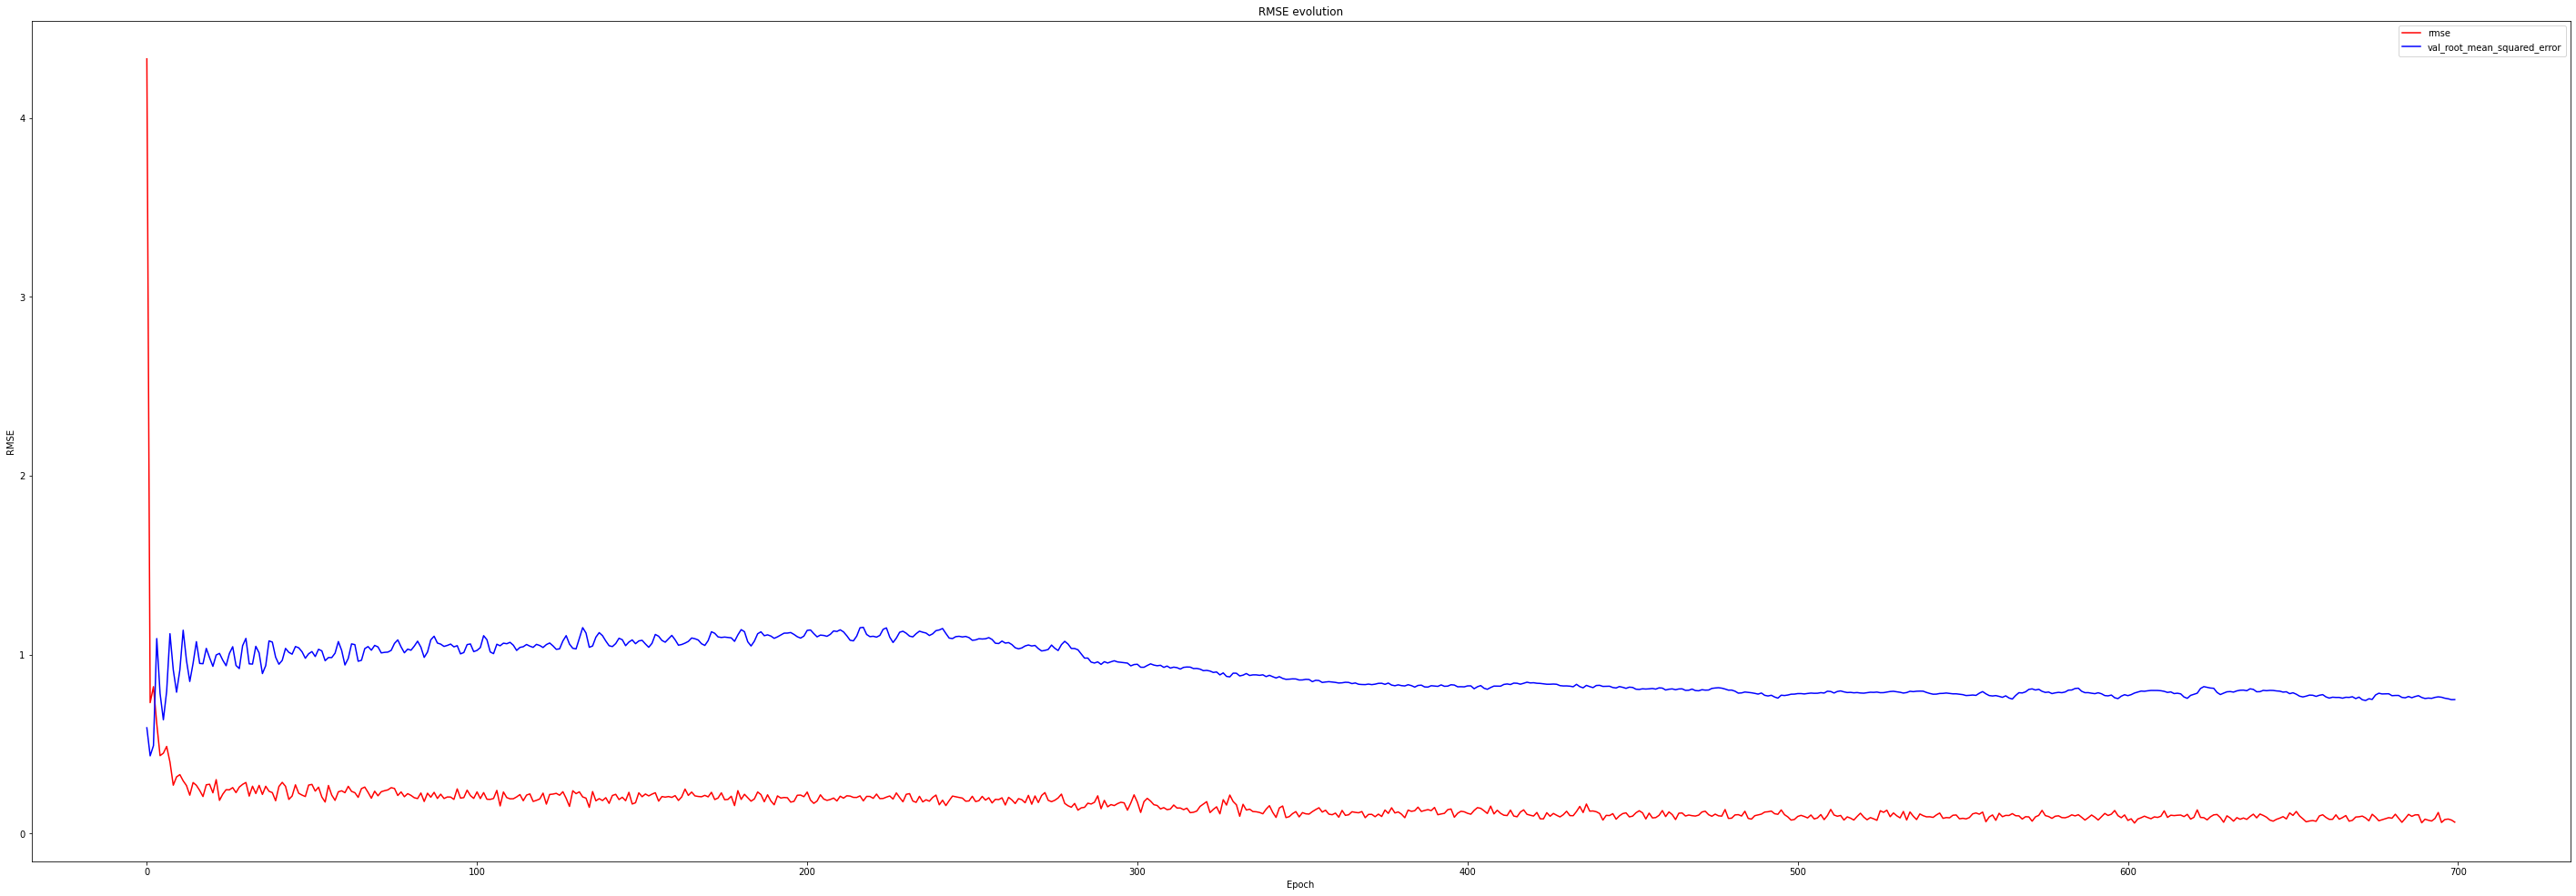

dict_keys(['loss', 'mse', 'root_mean_squared_error', 'val_loss', 'val_mse', 'val_root_mean_squared_error'])


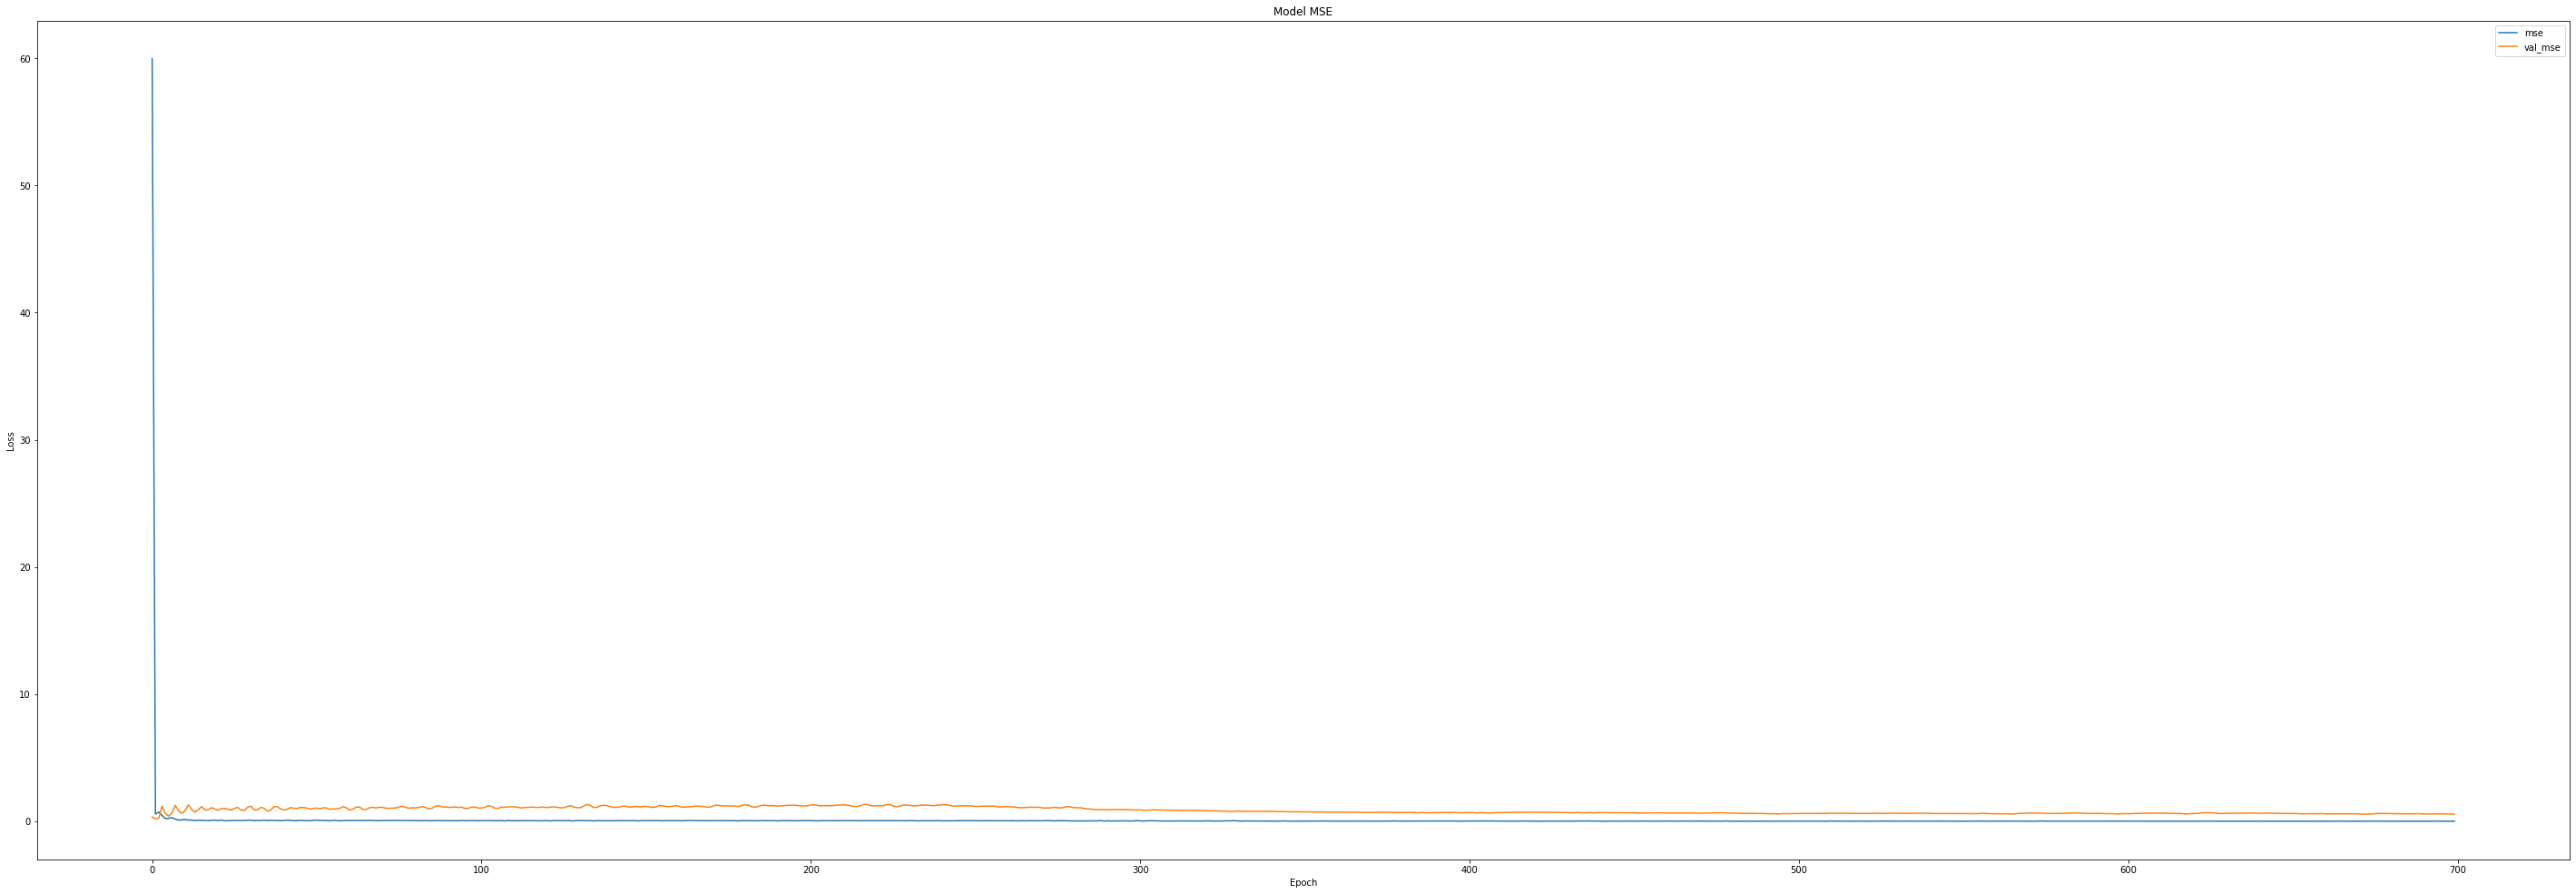

In [27]:
########################################################## - Plotting - ################################################################# 

#Plot the rmse evolution
def plot_rmse_evolution(history, epochs):
    print(history.history.keys())
    plt.figure(figsize=(50,17))
    plt.plot(history.history['root_mean_squared_error'], color='red', label='rmse')
    plt.plot(history.history['val_root_mean_squared_error'], color='blue', label='val_root_mean_squared_error')
    plt.title('RMSE evolution')
    plt.xticks(range(0, epochs + 100, 100), range(0, epochs + 100, 100))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


#Plot Loss evolution
def plot_MSE_evolution(history, epochs):
    print(history.history.keys())
    plt.figure(figsize=(50,17))
    plt.plot(history.history['mse'], label='mse')
    plt.plot(history.history['val_mse'], label='val_mse')
    plt.title('Model MSE')
    plt.xticks(range(0, epochs + 100, 100), range(0, epochs + 100, 100))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()    

#Plotting results
def plot_predictions(source_data, predictions, dates2predict):
    #all the dates
    dates = pd.DataFrame(source_data.reset_index()['data'].values)
    dates2predict = pd.DataFrame(dates2predict)
    complete_dates = np.array(pd.concat([dates, dates2predict], ignore_index=True)).flatten()

    #all the data
    data = pd.DataFrame(source_data.values)
    predictions = pd.DataFrame(predictions).round(0).astype(int)
    complete_data = np.array(pd.concat([data, predictions], ignore_index=True)).flatten()

    plt.figure(figsize=(25,17))
    plt.plot(range(len(source_data)), source_data, color='green', label='Confirmed')
    plt.plot(range(len(source_data)-1, len(source_data)+len(predictions)-1), predictions, color='red', label='Prediction')
    plt.xticks([x  for x in range(0, len(complete_dates))], complete_dates[[x  for x in range(0, len(complete_dates))]], rotation=30)
    plt.title('Confirmed Cases of COVID-19')
    plt.ylabel('Cases')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

#plot_predictions(source_data_copy, predictions, dates2predict)
plot_rmse_evolution(history, epochs)
plot_MSE_evolution(history, epochs)